---
title: "Dask-backed (lazy) resampling"
categories: [xarray]
date: 2025-04-11
---

## Example on how to spatially resample a xarray Dataset or DataArray with dask using `odc.algo.xr_reproject`

In [1]:
import xarray as xr
import rioxarray
from rasterio.enums import Resampling
from odc.algo import xr_reproject
from odc.geo.geobox import GeoBox as GeoBox_, BoundingBox
from datacube.utils.geometry import GeoBox
from affine import Affine

In [2]:
def webcam_to_01(snow_cover: xr.DataArray):
    return xr.where(snow_cover == 2, 0, snow_cover)

In [3]:
ds_webcam = xr.open_zarr("./data/webcam_snow_cover.zarr")

In [4]:
ds_webcam

<xarray.Dataset> Size: 160MB
Dimensions:      (time: 1, y: 4250, x: 4700)
Coordinates:
  * time         (time) datetime64[ns] 8B 2021-07-15
  * x            (x) float64 38kB 6.563e+05 6.563e+05 ... 6.61e+05 6.61e+05
  * y            (y) float64 34kB 5.213e+06 5.213e+06 ... 5.209e+06 5.209e+06
Data variables:
    snow_cover   (time, y, x) float64 160MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    spatial_ref  int64 8B ...

### Needs of odc.algo.xr_reproject


#### Function signature
```python
def xr_reproject(
    src: DataArray | Dataset,
    geobox: GeoBox,
    resampling: str = "nearest",
    chunks: Tuple[int, int] | None = None,
    dst_nodata: NodataType | None = None,
    **kwargs: Unknown
) -> (DataArray | Dataset)
```

#### Gotchas
* `geobox: GeoBox` is a `datacube.utils.geometry` not a `odc.geo.geobox`: this needs to be constructed first (see notes below)
* any `src: DataArray | Dataset` needs to have a `.odc.geobox` and `.odc.crs` attribute.

### Construction of a geobox

In [5]:
xmin, xmax = 656320.0, 661020.0
ymax, ymin = 5213480.0, 5209240.0

In [6]:
lower_res = 20 # target resolution in meters

### Version 1

In [7]:
width = int((xmax - xmin) / lower_res)
height = int((ymax - ymin) / lower_res)


geobox = GeoBox(
    width=width,
    height=height,
    affine=Affine(lower_res, 0.0, xmin, 0.0, lower_res * -1, ymax),
    crs="epsg:25832",
)

### Version 2

In [8]:
bbox = BoundingBox(left=xmin, top=ymax, bottom=ymin, right=xmax)
geobox_ = GeoBox_.from_bbox(bbox=bbox, crs=25832, resolution=lower_res)
geobox_2 = GeoBox(
    width=geobox_.width, height=geobox_.height, affine=geobox_.affine, crs="epsg:25832"
)

In [9]:
geobox_2 = GeoBox(
    width=geobox_.width, height=geobox_.height, affine=geobox_.affine, crs="epsg:25832"
)

In [10]:
assert geobox == geobox_2

## Perform computation on dataset - this often leads to some part of the spatial ref getting lost...

In [11]:
# snow cover as 0 and 1
snow_cover = webcam_to_01(ds_webcam.snow_cover)

## Setting crs for spatial_ref

In [12]:
if snow_cover.odc.geobox.crs is None:
    print("Dataset's missing the crs")

Dataset's missing the crs


In [13]:
# this makes .spatial_ref and .geobox available (actually .geobox is added by datacube)
# (not sufficient anymore)
# snow_cover.rio.write_crs("epsg:25832", inplace=True)

In [14]:
# (not sufficient anymore)
# snow_cover["spatial_ref"] = ds_webcam.spatial_ref

In [15]:
snow_cover = snow_cover.odc.assign_crs(25832)

In [16]:
assert snow_cover.odc.crs

## Perform actual resampling

In [18]:
snow_cover_downsampled = xr_reproject(snow_cover, geobox, resampling=Resampling.mode)

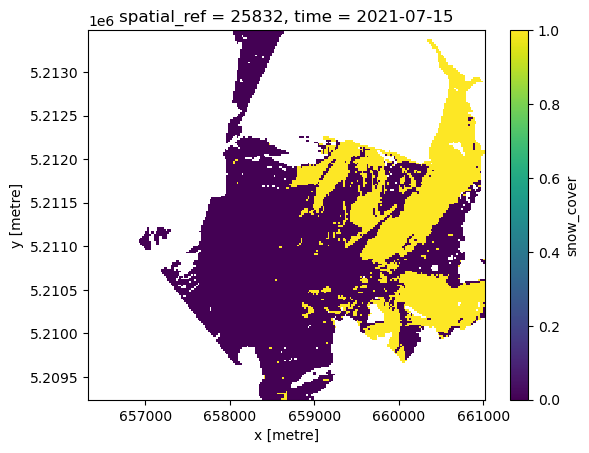

In [19]:
snow_cover_downsampled.plot()